### **Load Library**

In [ ]:
from google.colab import drive

# Mount Google-Drive Directory
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from scipy import stats
from google.colab import userdata
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
FOLDER_PATH = userdata.get("FOLDER_PATH")
%cd $FOLDER_PATH

/content/gdrive/MyDrive/AI Models/SupervisedLearning/regression-crop-yield


### **Load Dataset**

In [ ]:
# Load data from kaggle
def pandas_df(path: str, file_name: str) -> pd.DataFrame:

    path = os.path.join(path, f"{file_name}")

    return pd.read_csv(path)


In [ ]:
# Load processed data
FILE_NAME = "processed/crop_yield_dataset.csv"
df = pandas_df(FOLDER_PATH, FILE_NAME)
df.head()

,region,soil_type,crop,rainfall_mm,temperature_celsius,fertilizer_used,irrigation_used,weather_condition,days_to_harvest,yield_success,crop_yield
0,west,sandy,cotton,897.077239,27.676966,no,yes,cloudy,122,yes,6.555816
1,south,clay,rice,992.673282,18.026142,yes,yes,rainy,140,yes,8.527341
2,north,loam,barley,147.998025,29.794042,no,no,sunny,106,yes,1.127443
3,north,sandy,soybean,986.866331,16.644190,no,yes,rainy,146,yes,6.517573
4,south,silt,wheat,730.379174,31.620687,yes,yes,cloudy,110,yes,7.248251


### **Model Implementation**

In [ ]:
pandas_df = df.copy()
print(f"We have {pandas_df.shape[0]} records in our source dataset")

# split target variable into it's own dataset
target_col = "crop_yield"
X_all = pandas_df.drop(labels=target_col, axis=1)
y_all = pandas_df[target_col]

We have 1000000 records in our source dataset


#### **Train/Test Split**

In [ ]:
# test / train split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.8, random_state=42)
print(f"We have {X_train.shape[0]} records in our training dataset")
print(f"We have {X_test.shape[0]} records in our test dataset")

We have 800000 records in our training dataset
We have 200000 records in our test dataset


#### **Feature Encoding & Scaling**

In [ ]:
# Select Columns
categorical_X_cols = X_train.select_dtypes("object").columns
numerical_X_cols = X_train.select_dtypes("number").columns

# Encoding & Scaling
sc = StandardScaler()
oh = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

X_train_ = X_train.copy()
# Feature Scaling
for c in numerical_X_cols:
    X_train_[c] = sc.fit_transform(X_train_[[c]]).ravel()

# Feature Encodings
for c in categorical_X_cols:
    cat_feature = oh.fit_transform(X_train_[[c]])
    X_train_ = pd.concat([X_train_, cat_feature], axis=1)
    X_train_.drop(columns=[c], inplace=True)

X_train_  = X_train_.reset_index(drop=True)

In [ ]:
X_train_.head()

,rainfall_mm,temperature_celsius,days_to_harvest,region_east,region_north,region_south,region_west,soil_type_chalky,soil_type_clay,soil_type_loam,...,crop_wheat,fertilizer_used_no,fertilizer_used_yes,irrigation_used_no,irrigation_used_yes,weather_condition_cloudy,weather_condition_rainy,weather_condition_sunny,yield_success_no,yield_success_yes
0,1.299211,0.767268,-0.980873,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,-1.426747,-0.389472,-0.634162,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.382829,0.352719,0.598590,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-1.263925,-1.108459,-0.133356,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.720423,-1.285003,-0.634162,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


#### **Feature Selection**

In [ ]:
from sklearn.feature_selection import SelectPercentile, r_regression, mutual_info_regression

select_X = SelectPercentile(mutual_info_regression, percentile=25)

X_train_best = select_X.fit_transform(X_train_, y_train)
selected_features = X_train_.columns[select_X.get_support(indices=True)]

In [ ]:
# X_train_[selected_features]

#### **Model Selection**

In [ ]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

##### Train Model

In [138]:
# Initialize scalers and encoder
scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False)

# Initialize the baseline model
baseline_model = DecisionTreeRegressor()

# Scale target variable
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# Create column transformer
column_transformer = make_column_transformer(
    (scaler, make_column_selector(dtype_include=np.number)),
    (encoder, make_column_selector(dtype_include=object)),
    remainder='drop'
)

# Create pipeline with Ridge regression
pipeline_model = make_pipeline(column_transformer, Ridge())
pipeline_model.fit(X_train, y_train_scaled)

# Evaluate the model
def evaluate_model(model, X, y_true):
    """Evaluate the model and return performance metrics."""
    y_pred = model.predict(X)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    return mse, mae, rmse

# Training metrics
train_mse, train_mae, train_rmse = evaluate_model(pipeline_model, X_train, y_train_scaled)

# Testing metrics
test_mse, test_mae, test_rmse = evaluate_model(pipeline_model, X_test, y_test_scaled)

# Compile results into a DataFrame
results = pd.DataFrame({
    "mse": [train_mse, test_mse],
    "mae": [train_mae, test_mae],
    "rmse": [train_rmse, test_rmse]
}, index=["train", "test"]).round(3)

print(results)

         mse    mae   rmse
train  0.087  0.235  0.295
test   0.087  0.235  0.295


##### Cross-Validation (Optional)

In [234]:
# Initialize KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=43)

# Define the baseline model
baseline_model = LinearRegression()

# Define column transformer
column_transformer = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse_output=False), make_column_selector(dtype_include=object)),
    remainder='drop'
)

# Function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    """Calculate and return evaluation metrics."""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    return {"mse": mse, "mae": mae, "rmse": rmse}

# Function to compute average scores across folds
def compute_average_scores(scores):
    """Calculate average metrics across folds."""
    metric_names = list(next(iter(scores.values())).keys())
    score_values = np.array([list(score.values()) for score in scores.values()])
    average_scores = np.mean(score_values, axis=0)
    return {metric: np.round(value, 3) for metric, value in zip(metric_names, average_scores)}

# Custom cross-validation function
def custom_cross_validation(X, y):
    """Perform custom K-Fold cross-validation and return average scores."""
    train_scores = {}
    test_scores = {}

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
        # Split data into training and validation sets
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # Train pipeline
        pipeline = make_pipeline(column_transformer, baseline_model)
        pipeline.fit(X_train_fold, y_train_fold)

        # Compute metrics for training data
        y_train_pred = pipeline.predict(X_train_fold)
        train_scores[fold_idx] = calculate_metrics(y_train_fold, y_train_pred)

        # Compute metrics for validation data
        y_val_pred = pipeline.predict(X_val_fold)
        test_scores[fold_idx] = calculate_metrics(y_val_fold, y_val_pred)

    # Compute average scores across folds
    avg_train_scores = compute_average_scores(train_scores)
    avg_test_scores = compute_average_scores(test_scores)

    return avg_train_scores, avg_test_scores

# Perform cross-validation
avg_train_scores, avg_test_scores = custom_cross_validation(X_train, y_train)

# Create DataFrame to display results
cv_results = pd.DataFrame([avg_train_scores, avg_test_scores], index=["Train_KFold", "Val_KFold"])
cv_results.columns = [col.upper() for col in cv_results.columns]

print(cv_results)


              MSE    MAE  RMSE
Train_KFold  0.25  0.399   0.5
Val_KFold    0.25  0.399   0.5


##### Hyper-optimizer

In [226]:
from sklearn.model_selection import GridSearchCV

# Initialize KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=43)

# Define the baseline model
baseline_model = LinearRegression()

# Define column transformer
column_transformer = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse_output=False), make_column_selector(dtype_include=object)),
    remainder='drop'
)

# Define paramters to tune.
params = {}
params["linearregression__fit_intercept"] = [True, False]
params["linearregression__positive"] = [True, False]

# Define grid-search parameter optimizer
pipeline = make_pipeline(column_transformer, baseline_model)

grid_pipe = GridSearchCV(
    pipeline, cv=kf, param_grid=params,
    scoring=["neg_mean_squared_error", "neg_mean_absolute_error"],
    refit="neg_mean_squared_error", n_jobs=-1
).fit(X_train, y_train_)

In [227]:
pd.set_option('display.max_colwidth', None)

filter_out = ["params", "mean_test_neg_mean_squared_error", "mean_test_neg_mean_absolute_error", "rank_test_neg_mean_squared_error"]
optimized_params = pd.DataFrame(grid_pipe.cv_results_)[filter_out].sort_values("rank_test_neg_mean_squared_error")
optimized_params["mean_test_neg_mean_squared_error"] = optimized_params["mean_test_neg_mean_squared_error"].apply(lambda s: s *-1)
optimized_params["mean_test_neg_mean_absolute_error"] = optimized_params["mean_test_neg_mean_absolute_error"].apply(lambda s: s *-1)

# Print Results
optimized_params.round(3)

,params,mean_test_neg_mean_squared_error,mean_test_neg_mean_absolute_error,rank_test_neg_mean_squared_error
1,"{'linearregression__fit_intercept': True, 'linearregression__positive': False}",0.087,0.235,1
3,"{'linearregression__fit_intercept': False, 'linearregression__positive': False}",0.087,0.235,1
0,"{'linearregression__fit_intercept': True, 'linearregression__positive': True}",0.087,0.235,3
2,"{'linearregression__fit_intercept': False, 'linearregression__positive': True}",0.298,0.443,4


##### Best Model

In [235]:
# Define Best Selected Model
best_model = LinearRegression(fit_intercept=True, positive=False)

# Define column transformer
column_transformer = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse_output=False), make_column_selector(dtype_include=object)),
    remainder='drop'
)

# Define grid-search parameter optimizer
pipeline = make_pipeline(column_transformer, best_model).fit(X_train, y_train_scaled)

# Training metrics
train_mse, train_mae, train_rmse = evaluate_model(pipeline, X_train, y_train_scaled)

# Testing metrics
test_mse, test_mae, test_rmse = evaluate_model(pipeline, X_test, y_test_scaled)

# Compile results into a DataFrame
results = pd.DataFrame({
    "mse": [train_mse, test_mse],
    "mae": [train_mae, test_mae],
    "rmse": [train_rmse, test_rmse]
}, index=["train", "test"]).round(3)

print(results)

         mse    mae   rmse
train  0.087  0.235  0.295
test   0.087  0.235  0.295


##### Model Diagnostics

In [237]:
# Residual Error Analysis
def model_diagnostic_analysis(title: str, model, X_values: list) -> None:
    _ , (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
    plt.style.use("ggplot")

    y_pred = model.predict(X_values)
    residuals = y_true - y_pred

    # Residuals vs. Predicted values
    ax1.scatter(residuals, y_pred, alpha=0.7)
    ax1.axhline(y=0, color='b', linestyle='--', linewidth=2)
    ax1.set_title(f"({title}) Residuals vs Predicted Values")
    ax1.set_xlabel("Predicted Values")
    ax1.set_ylabel("Residuals")

    # Histogram of Residuals
    ax2.hist(residuals, bins=15, edgecolor='k', alpha=0.7, color='b')
    ax2.set_title(f"({title}) Histogram of Residuals")
    ax2.set_xlabel("Residual")
    ax2.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [240]:
from sklearn.base import BaseEstimator

# Residual Error Analysis
def model_diagnostic_analysis(model: BaseEstimator, X_train: list, X_test: list) -> None:
    _ , (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), sharey=True)
    plt.style.use("ggplot")

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_error = y_train_scaled - y_train_pred
    test_error = y_test_scaled - y_test_pred

    # Train:
    ax1.scatter(train_error, train_pred, alpha=0.7)
    ax1.axhline(y=0, color='k', linestyle='--', linewidth=2)
    ax1.set_title("(Train) Residuals vs Predicted Values", fontsize=11)
    ax1.set_xlabel("Predicted Values")
    ax1.set_ylabel("Residuals")

    # Test:
    ax2.scatter(test_error, test_pred, alpha=0.7, color="green")
    ax2.axhline(y=0, color='k', linestyle='--', linewidth=2)
    ax2.set_title("(Test) Residuals vs Predicted Values", fontsize=11)
    ax2.set_xlabel("Predicted Values")
    ax2.set_ylabel("Residuals")

    plt.tight_layout()
    plt.show()

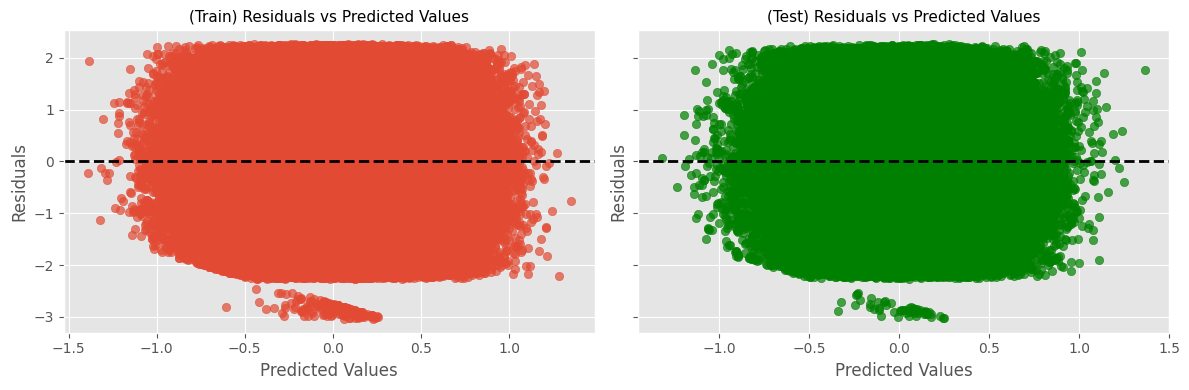

In [241]:
model_diagnostic_analysis(pipeline, X_train, X_test)

**Note:** Try to go learn about interpreting the model information provided above.